# Analysing Boston AirBnb Datasets

For this project i will follow the following steps using Cross-industry standard process for data mining(CRISP-DM)

1. Business Understanding
2. Data Understanding
3. Prepare data
4. Data Modeling
5. Evaluate The results
6. Deploy

# Business Understanding

What kind of answers we get from the data using the below questions

1. What time of year is the peak season in Boston?
2. Analyze what do people think about AirBnb based on reviews?
3. What are the important factors that influence price in boston ?

# Data Understanding

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from os import path, getcwd
import seaborn as sns
import csv
import helper
from datetime import datetime
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/prabhumanickavelu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:
# current path
cwd = path.join(getcwd(), 'data')

# data folders
cities = ['boston']

In [73]:
# boston data

boston_listings = pd.read_csv(path.join(cwd, cities[0], 'listings.csv'))
boston_reviews = pd.read_csv(path.join(cwd, cities[0], 'reviews.csv'))
boston_calendar  = pd.read_csv(path.join(cwd, cities[0], 'calendar.csv'))

bos_lis = boston_listings
bos_rev = boston_reviews
bos_cal = boston_calendar

In [74]:
# print boston rows and colimns

bos_lis.shape, bos_rev.shape, bos_cal.shape

((3585, 95), (68275, 6), (1308890, 4))

In [75]:
bos_lis.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


# Prepare data

In [76]:
bos_cal.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [77]:
bos_rev.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [78]:
# analyze and remove unwanted columns
bos_lis.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

# Transform certain features

# Calendar Dataset

In [79]:
# clean price columns as it is string value because of symbols
s1 = '$296,05.00'
out = float(str(s1).replace(',', '').split('$')[-1])
# out = s1.extra_people.map(lambda str_price: str_price[1:]).str.replace(',', '').astype(float)
out


29605.0

In [80]:
def clean_price(price_conv):
    '''
    Converts USD prices from string to numeric format
    
    Args:
        price_conv (string): USD price in string format (e.g., '$123,456.00')
    
    Returns:
        out (float): USD price in numeric format (e.g., 123456.00)
    '''
    out = float(str(price_conv).replace(',', '').split('$')[-1])
    return out
    

In [81]:
bos_cal.head(2)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN


In [82]:
def bool_to_num(s):
    '''
    Converts "first letter boolean" strings to integers
    
    Args:
        bool_string (string): 't', 'f' or other
    
    Returns:
        bool_number (int): 1, 0 or None
    '''
    
    if s == 'f':
        return 0
    elif s == 't':
        return 1
    return None

In [83]:
# a = '2019-08-15'
# b = '2018-07-13'

In [84]:
# (date_format(a) - date_format(b)).days

In [85]:
def days_between(d1, d2):
    '''
    INPUT
    d1, d2 - Start and End dates
    OUTPUT
    Difference between dates in number of days
    '''
    #d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")

    return abs((d2-d1).dt.days)

# Listings dataset

In [108]:
listing_df = bos_lis[['description','thumbnail_url','host_since','host_response_time','host_response_rate',
                           'host_acceptance_rate','host_has_profile_pic','host_identity_verified',
                           'neighbourhood_cleansed','neighbourhood_group_cleansed','property_type','room_type',
                           'accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price',
                           'security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights',
                           'maximum_nights','availability_365','number_of_reviews','review_scores_rating',
                           'instant_bookable','cancellation_policy','reviews_per_month']]

In [109]:
def clean_data(df):
    '''
    INPUT
    df - Raw dataframe
    OUTPUT
    Cleaned dataframe
    '''
    data_df = df.copy()

    # Clean columns with price amounts having '$' and ',' characters
    data_df['price'] = data_df[['price']].apply(lambda x : x.str.replace('$', '')).apply(lambda x : x.str.replace(',', '')).astype(float)
    data_df['security_deposit'] = data_df[['security_deposit']].apply(lambda x : x.str.replace('$', '')).apply(lambda x : x.str.replace(',', '')).astype(float)
    data_df['cleaning_fee'] = data_df[['cleaning_fee']].apply(lambda x : x.str.replace('$', '')).apply(lambda x : x.str.replace(',', '')).astype(float)
    data_df['extra_people'] = data_df[['extra_people']].apply(lambda x : x.str.replace('$', '')).apply(lambda x : x.str.replace(',', '')).astype(float)

    # Clean percentage columns with '%' character
    data_df['host_response_rate'] = data_df[['host_response_rate']].apply(lambda x : x.str.replace('%', '')).astype(float)
    data_df['host_acceptance_rate'] = data_df[['host_acceptance_rate']].apply(lambda x : x.str.replace('%', '')).astype(float)

    # Convert thumnail data as available or not-available
    data_df['thumbnail_available'] = np.where(data_df['thumbnail_url'].isnull(), 0, 1)
    data_df.drop('thumbnail_url', axis = 1, inplace = True)

    # Convert host since to number of days
    data_df['host_since'] = pd.to_datetime(data_df['host_since'], format='%Y-%m-%d')
    data_df['host_since'] = data_df[['host_since']].apply(lambda x : days_between(x,'2016-01-04'))

    # Convert amenities column to number of amenities
    amen_count = []
    for str in data_df.amenities.values:
        amenities = list(csv.reader([str[1:-2]]))[0]
        amen_count.append(len(amenities))

    data_df['amenities_count'] = amen_count
    data_df = data_df.drop(['amenities'], axis=1)

    return data_df

In [110]:
boston_df = clean_data(listing_df)
boston_df.drop('description', axis=1, inplace=True)
# boston_df.head()

In [113]:
# Calculate percentage of missing data in columns
df_nans = boston_df.isnull().sum()
data = [('feature', list(df_nans.index)), ('nan_count', list(df_nans.values))]
nan_counts = pd.DataFrame.from_items(data)

nan_counts = nan_counts.sort_values(by='nan_count')
print(nan_counts[nan_counts['nan_count'] != 0])
nan_percent = nan_counts['nan_count'].apply(lambda x : round(x/3818, 2)*100)
nan_counts['percent'] = nan_percent
print(nan_counts[nan_counts['nan_count'] > 0])

                         feature  nan_count
8                  property_type          3
13                          beds          9
12                      bedrooms         10
11                     bathrooms         14
3           host_acceptance_rate        471
2             host_response_rate        471
1             host_response_time        471
28             reviews_per_month        756
25          review_scores_rating        813
18                  cleaning_fee       1107
17              security_deposit       2243
15                   square_feet       3529
7   neighbourhood_group_cleansed       3585
                         feature  nan_count  percent
8                  property_type          3      0.0
13                          beds          9      0.0
12                      bedrooms         10      0.0
11                     bathrooms         14      0.0
3           host_acceptance_rate        471     12.0
2             host_response_rate        471     12.0
1            

/home/prabhumanickavelu/project1/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  after removing the cwd from sys.path.


In [114]:
# Remove columns with relatively high percentage of missing values
clean_df = boston_df.copy()
clean_df = clean_df[list(nan_counts[nan_counts['percent'] < 14.0]['feature'])]

# Split the data into features and target label
label_df = np.where(clean_df['price'] > clean_df['price'].median(), 0, 1)
feature_df = clean_df.drop(['price'], axis=1)

In [115]:
# create a function for preprocessing features like imputation, encoding categorical,, feature scaling
def process_features(feature_df):
    '''
    Perform feature encoding, imputes missing values, and scales features
    INPUT
    feature_df - Feature dataframe
    OUTPUT
    scaled_df - Perform feature encoding, imputes missing values, and 
    returns scaled features
    '''

    # Identify and encode categorical variables
    cat_feat = list(feature_df.select_dtypes(include = ['object']).columns)

    # Encode categorical variables
    feature_df = pd.get_dummies(feature_df, columns = cat_feat)

    # Impute missing values	
    fill_NaN = Imputer(missing_values=np.nan, strategy='most_frequent', axis=1)
    imputed_df = pd.DataFrame(fill_NaN.fit_transform(feature_df))
    imputed_df.columns = feature_df.columns
    imputed_df.index = feature_df.index

    # Feature scaling
    num_feat = list(imputed_df.select_dtypes(include = ['int64','float64']).columns)
    scaler = MinMaxScaler()
    scaled_df = imputed_df.copy()
    scaled_df[num_feat] = scaler.fit_transform(imputed_df[num_feat])

    return scaled_df

In [116]:
scaled_df = process_features(feature_df)

/home/prabhumanickavelu/project1/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Q1) What time of year is the peak season in Boston??

In [86]:
# for this we take calendar data from both cities to analyze
bos_cal.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [87]:
price_cols = ['price']
bool_cols = ['available']
bos_cal_1 = bos_cal

In [88]:
# clean price column
for col in price_cols:
    bos_cal_1[col] = bos_cal_1[col].apply(clean_price)
    

In [89]:
#convert available column from bool to num
for col in bool_cols:
    bos_cal_1[col] = bos_cal_1[col].apply(bool_to_num)

In [90]:
# calculate mean price for each month to analyze the peak season
# boston dataset

bos_cal_1['year'] = pd.DatetimeIndex(bos_cal_1['date']).year
bos_cal_1['month'] = pd.DatetimeIndex(bos_cal_1['date']).month
bos_cal_1['price'] = bos_cal_1['price']
# bos_cal_1.groupby(['year','month'])[['price']].mean().plot(kind="bar");

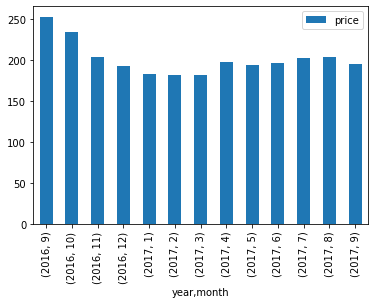

In [91]:
# plot seattle dataset

bos_cal_1.groupby(['year','month'])[['price']].mean().plot(kind='bar')

From the above graph it can be seen that in the month of september, the average hotel price is more than other months

# Q2) Analyze what do people think about AirBnb based on reviews?

In [92]:
# Assessing the data
bos_rev.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [93]:

# Some preprocessing prices and date from strings to float and datetime
def fix_price(x):
    """
    Convert price in string format with $ sign to a float
    input: a string including a price with optional $ symbol
    output: a float
    """
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)
    return x

bos_rev['date']=pd.to_datetime(bos_rev['date'])

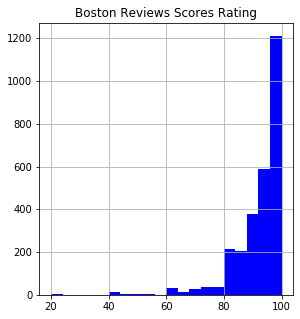

In [94]:
# We can use the listings dataset and the scores ratings to have an idea of what to expect from the reviews:

# Mostly positive reviews
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
bos_lis['review_scores_rating'].sort_values().reset_index(drop=True).dropna().hist(color='blue', bins=20)
plt.title('Boston Reviews Scores Rating');

the plot above shows that most of the reviews are positives score from scale 0 to 100

In [95]:
# Generating  a wordmap from the comments
# Importing classes
def gen_wordcloud(reviews, mask_file):
    # drop rows without reviews
    reviews = reviews.dropna(subset=['comments'])
    text = " ".join(review for review in reviews.comments)
    # remove punctation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # remove stopwords
    stopwords = set(STOPWORDS)
    # generating wordcloud
    # Loading a mask from seattle
    
    mask = np.array(Image.open(mask_file))
    wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white",
                     mask=mask, margin=3, scale=2).generate(nopunc)

    return wordcloud

In [96]:
boston_wc = gen_wordcloud(bos_rev,'boston-shape.png')

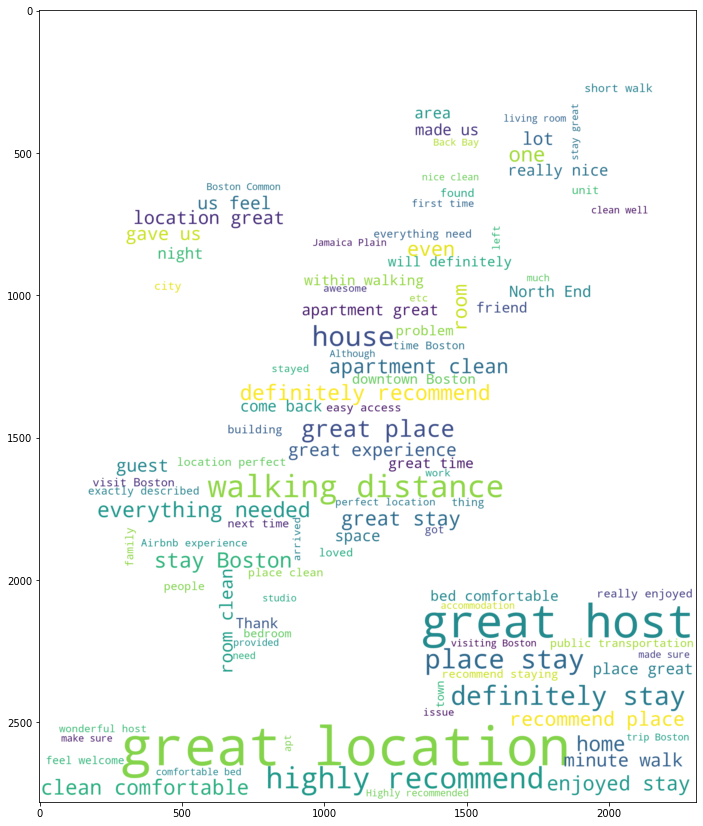

In [97]:
plt.figure(figsize=[40,20])
plt.subplot(1,3,1)
plt.imshow(boston_wc, interpolation='bilinear')

# classify reviews based on text

we will use vader sentiment analyzer that produces four sentiment metrics positive, negative, neutral and final metric compound score normalized sum of all of the lexicon ratings which have been standardised to range between -1 and 1

In [98]:
def print_sentiment_scores(sentence):
    """
    Prints the polarity scores from teh analyser
    input: a text sentence
    output: a list with the polarity scores (positivity, negativity, neutral, compound) of the sentence
    """
    snt = analyser.polarity_scores(sentence)

In [99]:
# Detect language of reviews and drop rows with non-english reviews
def safe_detect(text):
    """
    Detect language of the text
    input: a string with text
    output: the encoding of the language of the text (example 'en' for english), or 'None' if not found 
    """
    try:
        return(detect(text))
    except:
        return('None')

In [100]:
# We will remove all non-english reviews  

def review_preprocessing(reviews):
    """
    Preprocessing of reviews airbnb dataframe
    input: dataframe of airbnb reviews
    output: dataframe with language column added, limited to rows with reviews in english
    """
    
    df = reviews.dropna(subset=['comments']).copy()
    df['language'] = df['comments'].apply(safe_detect)
    return df[df['language']=='en']

In [101]:
# This will take some time, better to save the files once done
rv_boston = review_preprocessing(bos_rev)
rv_boston.to_csv('boston_prep_reviews.csv')

In [102]:
# Using the model 
# We add the polarity scores from Vader to the reviews datasets
analyser = SentimentIntensityAnalyzer()
boston_scores = [[d['neg'], d['neu'], d['pos'], d['compound']] for d in rv_boston.comments.apply(analyser.polarity_scores)]
rv_boston = pd.concat([rv_boston, pd.DataFrame(data = boston_scores, columns=['negative', 'neutral', 'positive', 'compound'])], 
                                           axis=1)

# visualization of boston dataset for scores of positive, negative, neutral and compound score

(0, 50000)

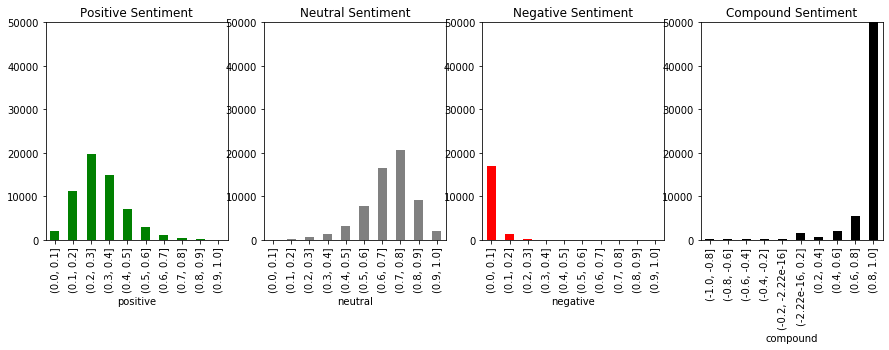

In [103]:
# Distributions for Boston
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
rv_boston.groupby(pd.cut(rv_boston["positive"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='green')
plt.title('Positive Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,2)
rv_boston.groupby(pd.cut(rv_boston["neutral"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='grey')
plt.title('Neutral Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,3)
rv_boston.groupby(pd.cut(rv_boston["negative"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='red')
plt.title('Negative Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,4)
rv_boston.groupby(pd.cut(rv_boston["compound"], np.arange(-1.0, 1.1, 0.2))).listing_id.count().plot(kind='bar', color='black')
plt.title('Compound Sentiment');
plt.ylim(0,50000)


In [104]:
print(rv_boston[rv_boston["compound"]>0.8].listing_id.count()/rv_boston.shape[0])

0.737064786249449


The plots show that only just over 6% of the reviews have a strong positive sentiment (>0.5) and the majority (61%) are in the 0.2 - 0.4 range, and most of the reviews are neutral (93%). However the negative sentiment is very low as the majority of comments have negativity < 0.1 The compound score shows that 73% of the guests in Boston give overall positive reviews

# Vader compound score VS listings Review Scores rating

In [105]:
# Calculate the mean of the compound score from Vader
comp_rev=rv_boston.groupby(['listing_id'])[['compound']].mean().reset_index().merge(
    bos_lis[['id', 'review_scores_rating']].dropna(), right_on='id', left_on='listing_id')

comp_rev.drop('id', axis=1, inplace=True)
comp_rev.set_index('listing_id', drop=True, inplace=True)
comp_rev.head()

,compound,review_scores_rating
listing_id,,
3353.0,0.870618,90.0
5506.0,0.938817,91.0
6695.0,0.903248,95.0
6976.0,0.801451,98.0
8792.0,0.815483,91.0


In [106]:
# Now we normalize two scores so that they can be compared, using min max normalization
def normalize(df):
    """
    Normalize the columns in the dataset containing compond score from Vader and rating score from airbnb
    input: a dataframe with listing_id, vader compound score (-1, 1) range and airbnb scores rating in (0,10) range
    output: a dataframe with normalized scores using min-max normalization
    """
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

normal_comp = normalize(comp_rev)
normal_comp.head()

,compound,review_scores_rating
listing_id,,
3353.0,0.935756,0.8750
5506.0,0.970287,0.8875
6695.0,0.952277,0.9375
6976.0,0.900735,0.9750
8792.0,0.907840,0.8875


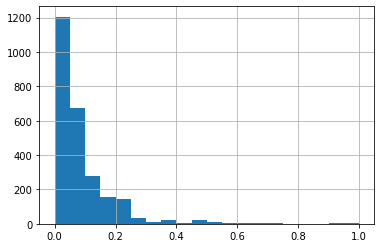

In [107]:
# Now we can compare the two:
# Differences, skewwd towards 0.3===> Good!!!

normal_comp['diff']=np.abs(normal_comp['compound'] - normal_comp['review_scores_rating'])
normal_comp['diff'].hist(bins=20)

mean of the VADER compound score and the review_scores_rating for most of listings is below 0.1.

# Q3) What are the important factors that influence price in boston ?

# model and evaluation

In [117]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [0.005, .01, 0.05, 0.1, 0.5, 1],
             'base_estimator__min_samples_split' : [2, 4, 6, 8, 10], 
             'base_estimator__max_depth' : [2, 4, 6, 8, 10]}

In [118]:
best_clf, X_train, X_test, y_train, y_test = helper.boost_classifier(clf, parameters, scaled_df, label_df)

/home/prabhumanickavelu/project1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [119]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [120]:
# Accuracy scores for Unoptimized model
test_accuracy, train_accuracy = helper.prediction_scores(clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.8448
Accuracy score on training data: 0.9996


In [121]:
# Accuracy scores for Optimized model
test_accuracy, train_accuracy = helper.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.8197
Accuracy score on training data: 0.8501


# important features 

In [122]:
def feature_plot(importances, X_train, y_train):
    '''
    INPUTS
    importances - Feature importances
    X_train, y_train - Training data
    OUTPUT
    Plot of five most important features
    '''

    # Displays the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (15,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#03d7fc', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#4e03fc', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 16)
    plt.xlabel("Feature", fontsize = 16)

    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()


Top 10 features by importance
------
['room_type_Entire home/apt' 'accommodates'
 'neighbourhood_cleansed_Dorchester' 'neighbourhood_cleansed_East Boston'
 'neighbourhood_cleansed_Jamaica Plain' 'neighbourhood_cleansed_Brighton'
 'amenities_count' 'neighbourhood_cleansed_Beacon Hill' 'minimum_nights'
 'bathrooms']


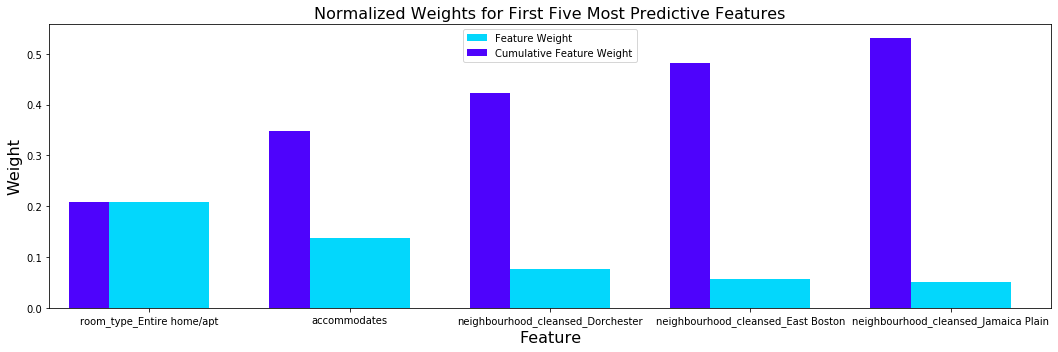

In [123]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 10 features by importance\n------")
print(X_train.columns.values[indices[:10]])

# Plot
feature_plot(importances, X_train, y_train)

# Can property description serve as an indicator of price?

In [124]:
# to analyze word level features using countervectorizer use description column
desc_df = listing_df['description']
text_df = helper.create_text_features(desc_df)

/home/prabhumanickavelu/Desktop/project1/helper.py:127: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  text_features = pd.SparseDataFrame([ pd.SparseSeries(text_features[i].toarray().ravel())                               for i in np.arange(text_features.shape[0]) ])
/home/prabhumanickavelu/Desktop/project1/helper.py:127: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  text_features = pd.SparseDataFrame([ pd.SparseSeries(text_features[i].toarray().ravel())                               for i in np.arange(text_features.shape[0]) ])
/home/prabhumanickavelu/project1/lib/python3.

In [125]:
# optimize model using GridSearch CV

In [126]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Create the parameters list to tune, using a dictionary.
parameters = {"n_estimators": [10, 50, 100],
              "learning_rate": [.01, 0.05, 0.1, 0.5, 1],
             'base_estimator__min_samples_split' : [2, 4, 6, 8, 10], 
             'base_estimator__max_depth' : [2, 4, 6, 8, 10]}

best_clf, X_train, X_test, y_train, y_test = helper.boost_classifier(clf, parameters, text_df, label_df)


/home/prabhumanickavelu/project1/lib/python3.6/site-packages/pandas/core/generic.py:3606: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)
/home/prabhumanickavelu/project1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [127]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [128]:
# Accuracy scores for Unoptimized model
test_accuracy, train_accuracy = helper.prediction_scores(clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7323
Accuracy score on training data: 0.9980


In [129]:
# Accuracy scores for Optimized model
test_accuracy, train_accuracy = helper.prediction_scores(best_clf, X_train, X_test, y_train, y_test)
helper.print_scores(test_accuracy, train_accuracy)

Accuracy score on testing data: 0.7472
Accuracy score on training data: 0.8745


In [130]:
def create_wordcloud(importances, X_train, y_train):
    '''
    INPUTS
    importances - Feature importances
    X_train, y_train - Training data
    OUTPUT
    Word colud of top 50 word features
    '''
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:50]]
    values = importances[indices][:50]
    word_dict = dict(zip(columns, values))

    # Generate wordcloud using top 50 word features
    wordcloud = WordCloud().generate_from_frequencies(word_dict)
    plt.figure(figsize=(50, 30))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

['room' 'has' 'my' 'charlestown' 'queen' 'shared' 'marathon' 'amenities'
 'level' 'bedrooms' 'very' 'just' 'have' '20' 'families' 'luxury' 'mins'
 'fitness' 'end' 'free' 'inquire' 'fluffy' 'master' 'bus' 'newbury'
 'ashmont' 'perfectly' 'tvs' 'rooftop' 'allow' 'beacon' 'not' 'steps'
 'deck' 'perfect' 'almost' 'steel' 'theaters' 'suite' 'is' 'roommate' 'as'
 'these' 'me' 'university' 'luxurious' 'renovated' 'modern' 'brings'
 'heart']


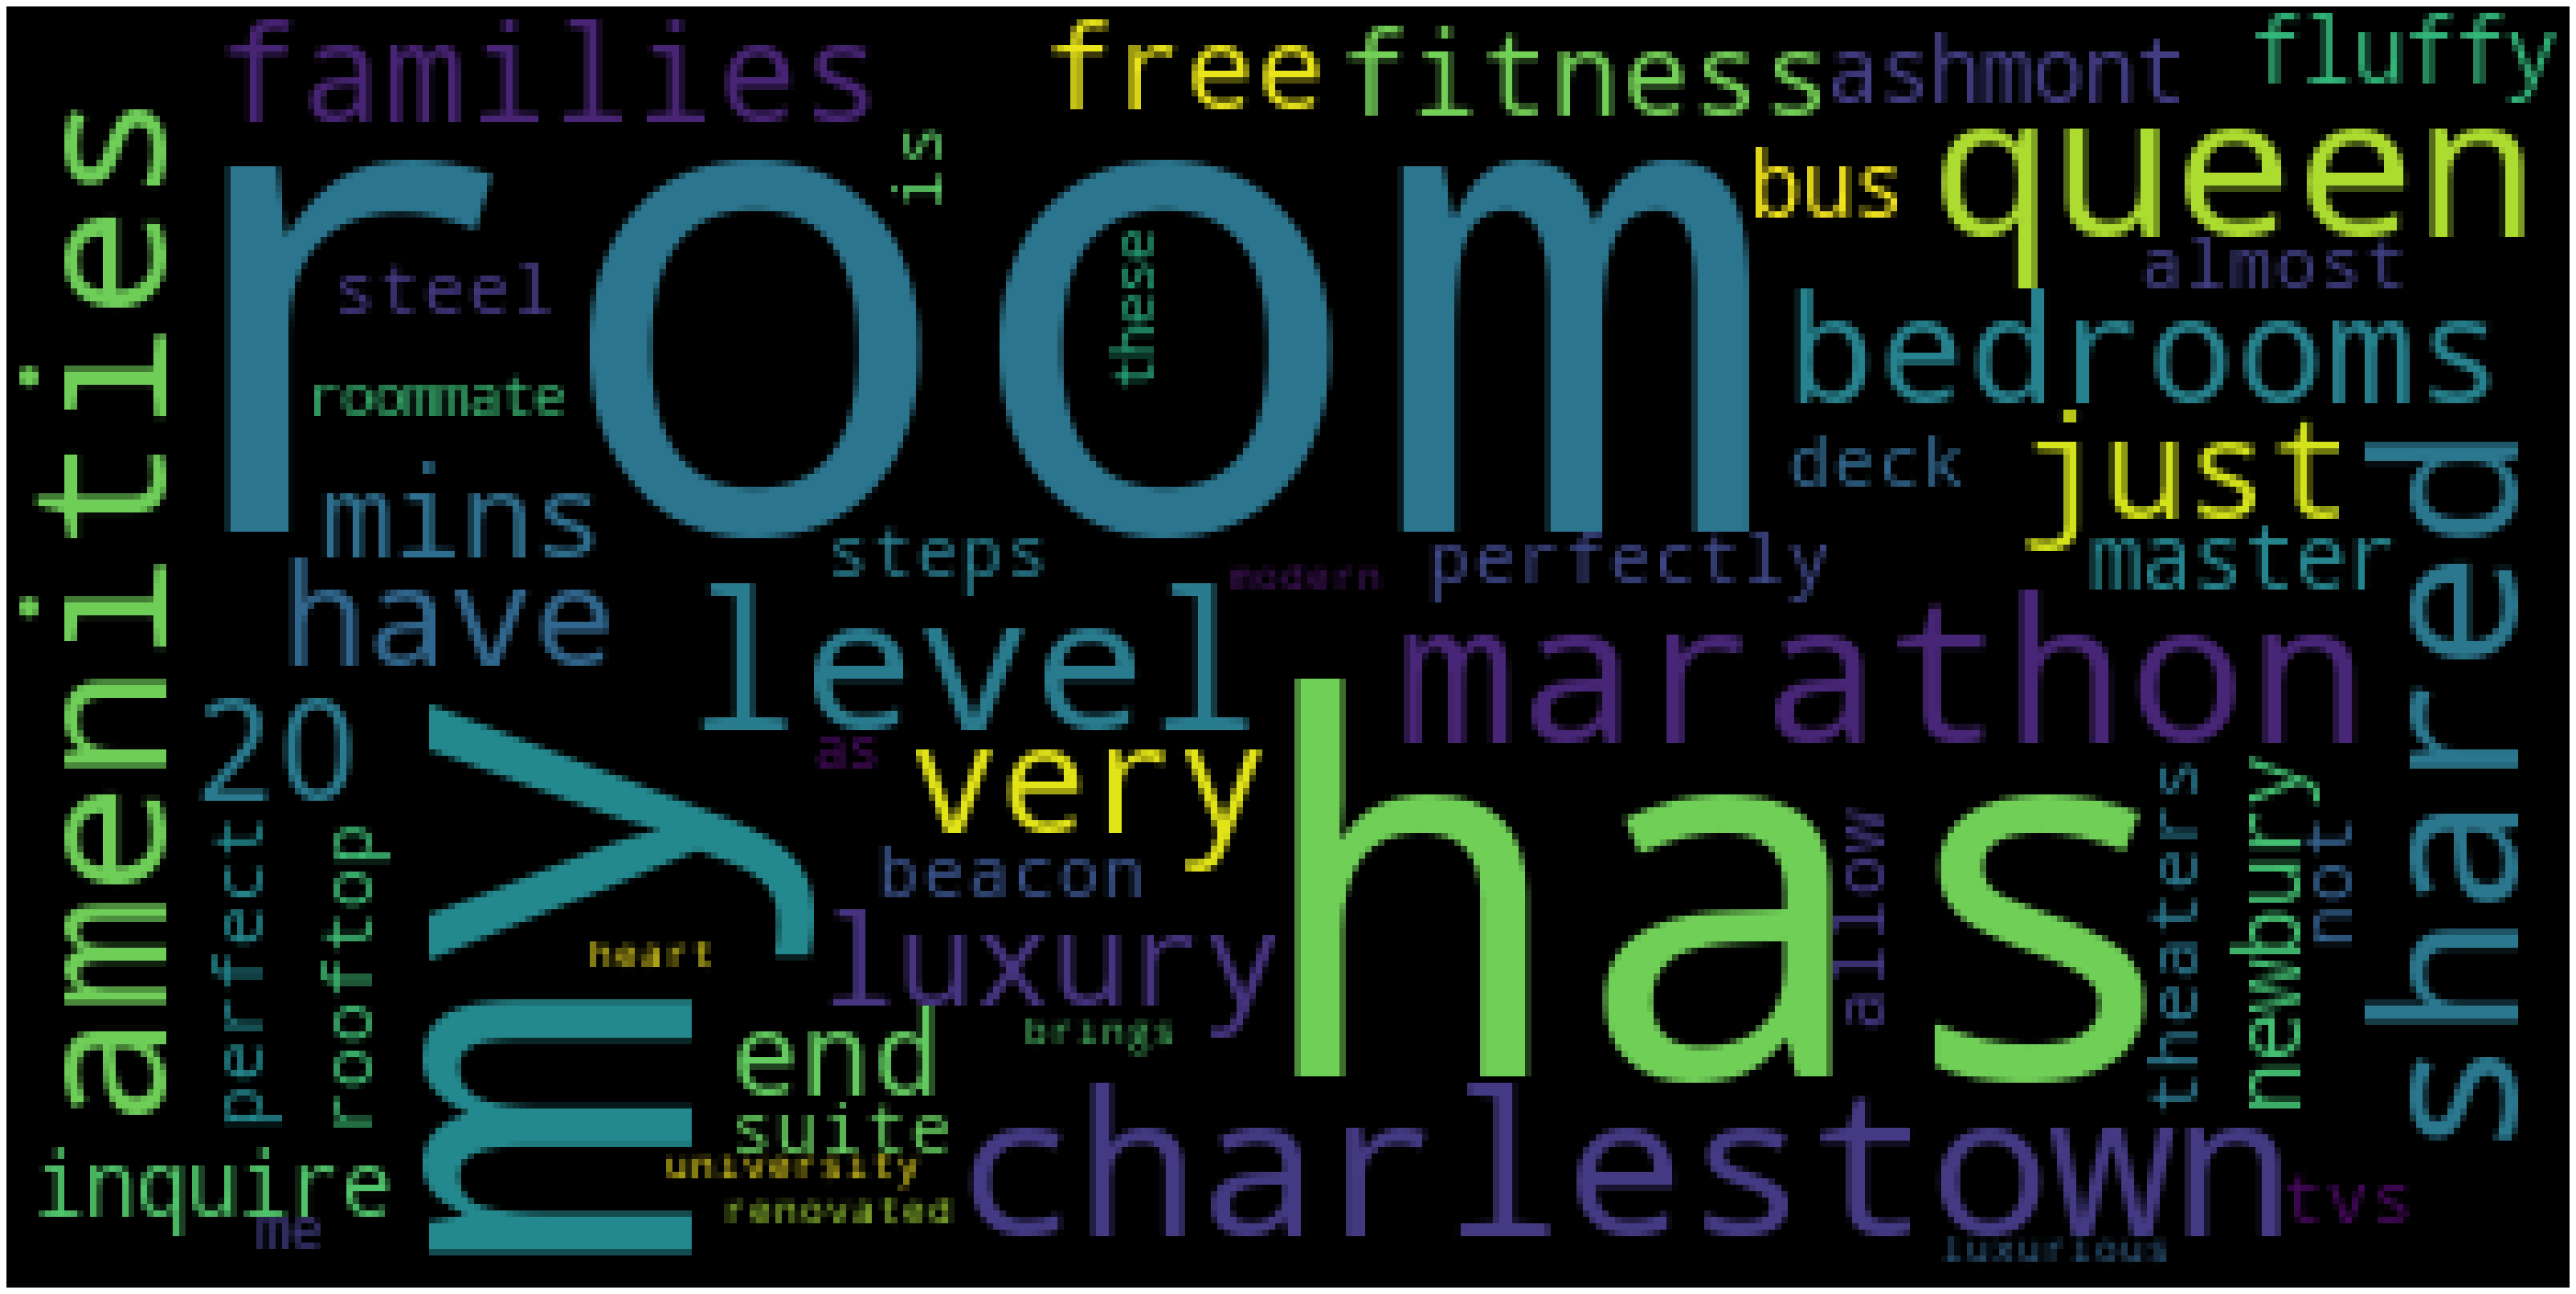

In [131]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
print(X_train.columns.values[indices[:50]])
# WordCloud
create_wordcloud(importances, X_train, y_train)